We will model the path of interest rates using the Hull-White model, that we calibrate with a yield curve we constructed (refer to the code UST_spot_YC_Construction_v1.ipynb for details)

Modeling the future path of short-end interest rate with the one-factor Hull-White model. This model is an extension of the Vasicek model, which includes a mean-reverting level that is also time-dependent. I used the Yield Curve I constructed in another project for calibration, and used Monte Carlo simulations following a Normal Law.

The Hull-White Short Rate Model is defined as:

dr(t)= a * (alpha(t) - r(t))dt + sigma*dWt

where a, a constant, is the speed of mean reversion, and sigma, a constant, is the volatility of short-term interest rates. This models also has alpha, the mean reverting level, a time dependant variable.

The short rate r(t) is given a distribution with the properties:

E[r(t) | Fs] = r(s)e^(-a(t-s)) + alpha(t) - alpha(s)e^(-a(t-s))

Var[r(t) | Fs] = (sigma^2 / 2a) * [1 - e^(-2a(t-s))]

where:
alpha(t) = forwardrate(0, t) + (sigma^2 / 2a^2) * ((1 - e^-at)^2)

I still face challenges with this simulation of short IR, because I need to use an alpha of around 1 to get coherent values. Usual values for a are around 0.01 to 0.1 for short term interest rates.

Steps in the code:
- Construction of yield curve via UST data feed (done in the UST_spot_YC_Construction_v1 jupyter notebook file of this repository)
- Initialize our model, with a and sigma, and computation of alpha(t).
- Simulate the path with Monte Carlo, following a Normal Law (0, 1)
- Compute the short-term rate values predicted by the model
- Show all the simulated paths on a plot
- Compare the short-term rate values predicted by the model with the mean of our Monte Carlo short-term rates simulations


First we generate the YC. Details on this Yield Curve construction are in UST_spot_YC_Construction_v1 jupyter notebook file:

Fetched raw data from USDT website!
Listed bond helpers with par yields for all maturities!
The UST Spot Yield Curve is calibrated!
As of the October 25th, 2024, the discount factor on a 10Y UST is 0.6551522857415304


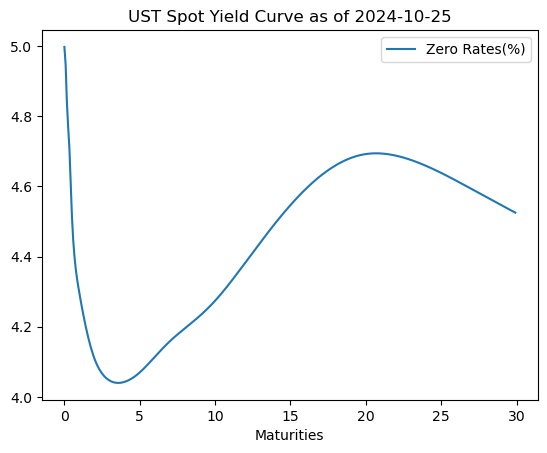

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
from datetime import datetime

class UST_spot_YieldCurve:
    def __init__(self, date: ql.Date) -> None:
        self.as_of_date = date
        ql.Settings.instance().evaluationDate = self.as_of_date
        self.api_str = f"{self.as_of_date.year()}{self.as_of_date.month():02d}"
        self.api_url = f"https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xml?data=daily_treasury_yield_curve&field_tdr_date_value_month={self.api_str}"
        self.raw_data = {}
        self.par_yields = self.get_raw_xml_data()
        if len(self.raw_data) > 2 :
            print("Fetched raw data from USDT website!")
        else:
            raise Exception("Error fetching data from USDT website!")

        # Conventions via QuantLib
        self.calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        self.business_convention = ql.ModifiedFollowing
        self.day_count = ql.ActualActual(ql.ActualActual.ISDA)
        self.settlement_days = 1
        self.face_amount = 100
        self.coupon_frequency = ql.Period(ql.Semiannual)
        self.end_of_month = False

        # Calibrate the yield curve
        self.calibrate()
        
    #Get discount factor on given maturity via the YC
    def get_discount_factor(self, date: ql.Date):
        return self.yield_curve.discount(date)
    
    #Create handle to allow objects to reference the YC
    def get_YC_handle(self):
        if self.yield_curve is not None:
            return ql.YieldTermStructureHandle(self.yield_curve)
        else:
            raise Exception("Error calibrating yield curve!")

    def get_raw_xml_data(self):
        response = requests.get(self.api_url)

        if response.status_code == 200:
            # Parse the XML content
            root = ET.fromstring(response.content)

            # Define namespaces, with Atom feed (data feed), m for metadata and d for data elements of the XML
            namespaces = {
                'atom': 'http://www.w3.org/2005/Atom',
                'm': 'http://schemas.microsoft.com/ado/2007/08/dataservices/metadata',
                'd': 'http://schemas.microsoft.com/ado/2007/08/dataservices'
            }

            # Find all entry tags
            entries = root.findall('.//atom:entry', namespaces)

            # Iterate through each entry tag
            for entry in entries:
                # Find the properties and content, inside each entry tag
                content = entry.find('atom:content', namespaces)
                properties = content.find('m:properties', namespaces)
                if properties is not None:
                    # Iterate through each property
                    # Extract the target date (NEW_DATE) property, in the d namespace, and convert it to a datetime object
                    new_date_str = properties.find('d:NEW_DATE', namespaces).text
                    new_date = datetime.strptime(new_date_str, "%Y-%m-%dT%H:%M:%S")

                    if ql.Date(new_date.day, new_date.month, new_date.year) == self.as_of_date:
                        #Loop that iterates through properties to find BC_ which gives a bond yield for a specific tenor
                        for prop in properties:
                            if (prop.tag.startswith('{http://schemas.microsoft.com/ado/2007/08/dataservices}BC_') 
                            and prop.tag != '{http://schemas.microsoft.com/ado/2007/08/dataservices}BC_30YEARDISPLAY'):
                                tag = prop.tag.split('}')[1]  # Remove namespace from the tag and keeping only the element name BC_XXX
                                period_str = tag.split("BC_")[1].replace("MONTH","M").replace("YEAR","Y")
                                ql_period = ql.Period(period_str)
                                raw_yield = float(prop.text)
                                self.raw_data.update({ql_period:raw_yield})                

        else:
            print("Failed to fetch XML data. Status code:", response.status_code)

    def get_spot_rates(self, months=360):
        spots = []
        tenors = []
        ref_date = self.as_of_date + self.settlement_days
        calc_date = ref_date
        for month in range(0, months):
            yrs = month / 12.0
            compounding = ql.Compounded
            freq = ql.Semiannual
            #Advances the ref_date by 'month' to compute the next spot rate
            d = self.calendar.advance(ref_date, ql.Period(month, ql.Months))

            #finds the ZC rate for the maturity 'yrs' on the YC, and stores the time to maturity
            zero_rate = self.yield_curve.zeroRate(yrs, compounding, freq)
            tenors.append(yrs)

            #We annualize the ZC rate and store it
            eq_rate = zero_rate.equivalentRate(
                self.day_count, compounding, freq, calc_date, d
            ).rate()
            spots.append(100 * eq_rate)
            
        return pd.DataFrame(
            list(zip(tenors, spots)),
            columns=["Maturities", "Zero Rates(%)"],
            index=[""] * len(tenors),
        )

    def calibrate(self):
        bond_helpers = []
        #All yields on the par yield curve provided by the UST website are on a bond-equivalent basis with semiannual compounding

        for tenor, par_yield in self.raw_data.items():
            maturity_date = self.as_of_date + tenor
            #Generate schedule of coupon payements with QL
            schedule = ql.Schedule(
                self.as_of_date,
                maturity_date,
                self.coupon_frequency,
                self.calendar,
                self.business_convention,
                self.business_convention,
                ql.DateGeneration.Backward,
                self.end_of_month,
            )
            #Generate the list of bonds, and connect the yields observed
            bond_helper = ql.FixedRateBondHelper(
                ql.QuoteHandle(ql.SimpleQuote(self.face_amount)),
                self.settlement_days,
                self.face_amount,
                schedule,
                [par_yield / 100.0],
                self.day_count,
                self.business_convention,
            )
            bond_helpers.append(bond_helper)
        print("Listed bond helpers with par yields for all maturities!")

        #YC is not smoothed especially at short end
        #We apply cubic interpolation to the logarithms of discount factor, rather than directly discount factos
        self.yield_curve = ql.PiecewiseNaturalLogCubicDiscount(
            self.as_of_date, bond_helpers, self.day_count
        )
        self.yield_curve.enableExtrapolation()
        print("The UST Spot Yield Curve is calibrated!")

as_of_date = ql.Date(25, 10, 2024)
us_yield_curve = UST_spot_YieldCurve(date=as_of_date)
spot_rates = us_yield_curve.get_spot_rates(months=360)
spot_rates.plot(x="Maturities", y="Zero Rates(%)", title=f"UST Spot Yield Curve as of {as_of_date.ISO()}")
print(f"As of the {as_of_date}, the discount factor on a 10Y UST is {us_yield_curve.get_discount_factor(date=ql.Date(25, 10, 2034))}")

Now that we have generated the YC, let's code the HW Short Rate model

In [8]:
class HullWhiteModel:
    def __init__(self, yield_curve, analysis_date, a=1, sigma=0.15, num_paths=10000, timestep=360, length=30):
        self.as_of_date = analysis_date
        self.yield_curve = yield_curve
        self.a = a  # Mean reversion speed
        self.sigma = sigma  # Volatility of the short rate
        self.num_paths = num_paths
        self.timestep = timestep
        self.length = length  # Projection horizon in years
        self.dt = 1 / timestep  # Discretization interval

        #Convention
        self.day_count = ql.Thirty360(ql.Thirty360.BondBasis)

        # Initial calibration
        self._calibrate()
        print("Default calibration done")

    def _calibrate(self):
        # Generate random paths using stochastic process
        self.seq = self.stochastic_process()
        print("Calibrated!")

    def get_initial_short_rate(self):
        # Approximate initial short rate based on yield curve, for example:
        return self.yield_curve.forwardRate(0, self.dt, ql.Compounded).rate()

    def get_alpha(self, time: float):
        # One day periods(proxy for short rate)
        #Be careful and use the instant forward rate f(0,t) (and not f(t,t+deltat)) 
        forwardrate = self.yield_curve.forwardRate(time, time + self.dt, ql.Compounded).rate()
        alpha = forwardrate + (self.sigma ** 2 / (2 * self.a ** 2)) * (1 - np.exp(-self.a * time)) ** 2
        return alpha
    
    def stochastic_process(self):
        #Initialize matrix for paths (num_paths x timestep + 1)
        #Using Fortan style to have one MC simulation per row
        paths = np.zeros((self.num_paths, self.timestep + 1), order='F')
        r0 = self.get_initial_short_rate()  # Initial short rate from yield curve
        paths[:, 0] = r0

        # Generate the time array in years (0, dt, 2dt...max_tenor))
        time = np.linspace(0, self.length, self.timestep + 1)

        for j in range(self.timestep):
            # Compute alpha, used for the drift term of the short-term rates (mu)
            alpha = self.get_alpha(j * self.dt) #Alpha is time-varying in this model
            mu = alpha * (1 - np.exp(-self.a * self.dt)) #drift of short-term rate over a discrete interval self.dt
            diffusion = self.sigma * np.sqrt(self.dt) * np.random.normal(0, 1, size=self.num_paths) #stochastic path over the discrete interval self.dt
            paths[:, j + 1] = paths[:, j] * (np.exp(-self.a * self.dt)) + mu + diffusion

        return time, paths

   

In [9]:
as_of_date = ql.Date(25, 10, 2024)
num_paths = 10000
timestep = 360
max_tenor = 30 # Years
yield_curve = us_yield_curve.get_YC_handle()
hw_model = HullWhiteModel(
    analysis_date=as_of_date,
    yield_curve=yield_curve,
    num_paths=num_paths,
    timestep=timestep,
    length=max_tenor,
)

Calibrated!
Default calibration done


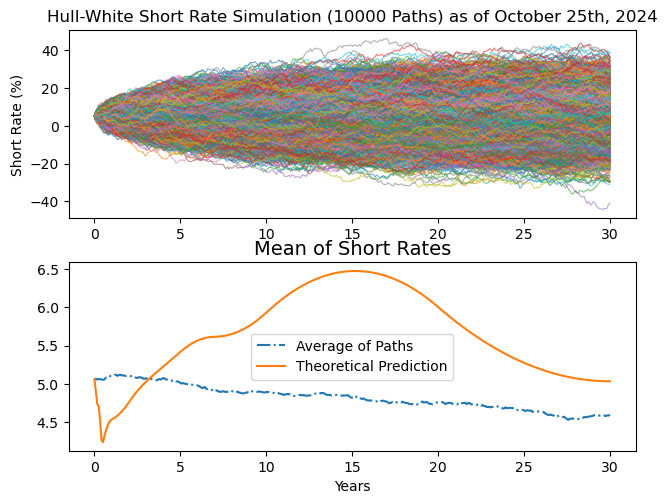

In [10]:
# Plotting the projected paths
time, paths = hw_model.stochastic_process()
fig, axs = plt.subplots(2)
fig.tight_layout()

# Plot each path
for i in range(num_paths):
    axs[0].plot(time, np.multiply(paths[i, :], 100), lw=0.8, alpha=0.6)

axs[0].set_title(f"Hull-White Short Rate Simulation ({num_paths} Paths) as of {as_of_date}")
axs[0].set_ylabel("Short Rate (%)")

# Plotting mean of every path
avg = [np.mean(paths[:, i]) * 100 for i in range(hw_model.timestep + 1)]
alphas = [hw_model.get_alpha(t) * 100 for t in time]
axs[1].plot(time, avg, "-.", label="Average of Paths")
axs[1].plot(time, alphas, "-", label="Theoretical Prediction")
axs[1].set_title("Mean of Short Rates", size=14)
axs[1].set_xlabel("Years")
axs[1].legend()

plt.show()